<a href="https://colab.research.google.com/github/londogard/londogard/blob/master/blog/2022-03-12-timeseries-pt-2/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# \[CA\]: Time Series #2 - Predicting Stock Prices (Time Series) using classical Machine Learning

`CA=Competence Afternoon`

To learn more about Time Series and how one can analyze them please view the other parts,

1. [Part One - Decomposing & Working with Time Series (theoretical)](https://blog.londogard/timeseries-pt-1)
2. [Part Two - Predicting Stock Prices (Time Series) using classical Machine Learning](https://blog.londogard/timeseries-pt-2)
3. [Part Three -Forecasting Cryptocurrency Prices (Time Series) using Deep Learning (PyTorch, Tensorflow/Keras & darts)](https://blog.londogard/timeseries-pt-3)

## Predicting Time Series 📈

Today we will move from learning how to analyze Time Series to actually predicting them using simple models and data.

We'll be predicting Stocks from the top tech companies like Apple & Google.  
In [part #3](https://blog.londogard/timeseries-pt-3) we'll move back to the crypto world!

To be able to predict the data we must understand it and we'll make a minor analysis.

### Installation & Imports

Feel free to ignore the cells and simply run them, the lazy style 🥱

Installing the important libraries...

In [45]:
from IPython.display import clear_output
!pip install -U pandas_datareader
!pip install plotly
!pip install matplotlib==3.1.3

clear_output()

And importing them...

In [46]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # linear algebra
import pandas_datareader as pdr
import seaborn as sns

from datetime import datetime

### Minor Analysis


In [47]:
df = pdr.get_data_yahoo(['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'GE'])
df.head()

Attributes  Adj Close                                                 \
Symbols          AAPL       GOOGL        AMZN       MSFT          GE   
Date                                                                   
2017-03-13  32.856758  864.580017  854.590027  60.405796  214.961868   
2017-03-14  32.807198  865.909973  852.530029  60.125748  212.658188   
2017-03-15  33.154182  868.390015  852.969971  60.443142  214.241943   
2017-03-16  33.208458  870.000000  853.419983  60.340446  214.169952   
2017-03-17  33.043243  872.369995  852.309998  60.555161  215.105865   

Attributes      Close                                                 ...  \
Symbols          AAPL       GOOGL        AMZN       MSFT          GE  ...   
Date                                                                  ...   
2017-03-13  34.799999  864.580017  854.590027  64.709999  229.692307  ...   
2017-03-14  34.747501  865.909973  852.530029  64.410004  227.230774  ...   
2017-03-15  35.115002  868.390015  852.969971  64.750000  228.923080  ...   
2017-03-16  35.172501  870.000000  853.419983  64.639999  228.846161  ...   
2017-03-17  34.997501  872.369995  852.309998  64.870003  229.846161  ...   

Attributes       Open                                                 \
Symbols          AAPL       GOOGL        AMZN       MSFT          GE   
Date                                                                   
2017-03-13  34.712502  860.830017  851.770020  65.010002  232.538467   
2017-03-14  34.825001  863.750000  853.549988  64.529999  228.923080   
2017-03-15  34.852501  867.940002  854.330017  64.550003  227.307693   
2017-03-16  35.180000  870.530029  855.299988  64.750000  229.230774   
2017-03-17  35.250000  873.679993  853.489990  64.910004  229.615387   

Attributes       Volume                                               
Symbols            AAPL      GOOGL       AMZN        MSFT         GE  
Date                                                                  
2017-03-13   69686800.0  1166600.0  1909700.0  20100000.0  3924414.0  
2017-03-14   61236400.0  1061700.0  2130600.0  14280200.0  2964208.0  
2017-03-15  102767200.0  1332900.0  2562200.0  24833800.0  3268564.0  
2017-03-16   76928000.0  1104500.0  1842300.0  20674300.0  2756910.0  
2017-03-17  175540000.0  1868300.0  3384400.0  49219700.0  5673070.0  

[5 rows x 30 columns]

Looks fine, but how much data did we download?  
We can view the `.index` which is a `DateTimeIndex` and figure out how it stretches.

In [48]:
df.index[0],df.index[-1]

(Timestamp('2017-03-13 00:00:00'), Timestamp('2022-03-11 00:00:00'))

Hmm, 5 years, that should be enough to find some kind of patterns.  
Now let us analyze this data further by looking at if the stocks correlate somehow! 🤠
  
> **N.B.** this analysis was first done by Heidi Mach, it's something I would never have done myself. Really cool results incoming!

In [49]:
df['Adj Close'].corr().style.background_gradient(cmap="Blues")

Symbols,AAPL,GOOGL,AMZN,MSFT,GE
Symbols,,,,,
AAPL,1.000000,0.951499,0.935116,0.978268,-0.283789
GOOGL,0.951499,1.000000,0.866575,0.960291,-0.192826
AMZN,0.935116,0.866575,1.000000,0.944313,-0.499768
MSFT,0.978268,0.960291,0.944313,1.000000,-0.374930
GE,-0.283789,-0.192826,-0.499768,-0.374930,1.000000


Holy macaron, that's a lot more correlated data than I expected! 🙀  

The `seaborn` library has a function called `pairplot` which plots this correlation, but using the points which is visually interesting in comparison to simply seeing the table above.

In [50]:
df = df['Adj Close']
df = df.drop(columns="GE")

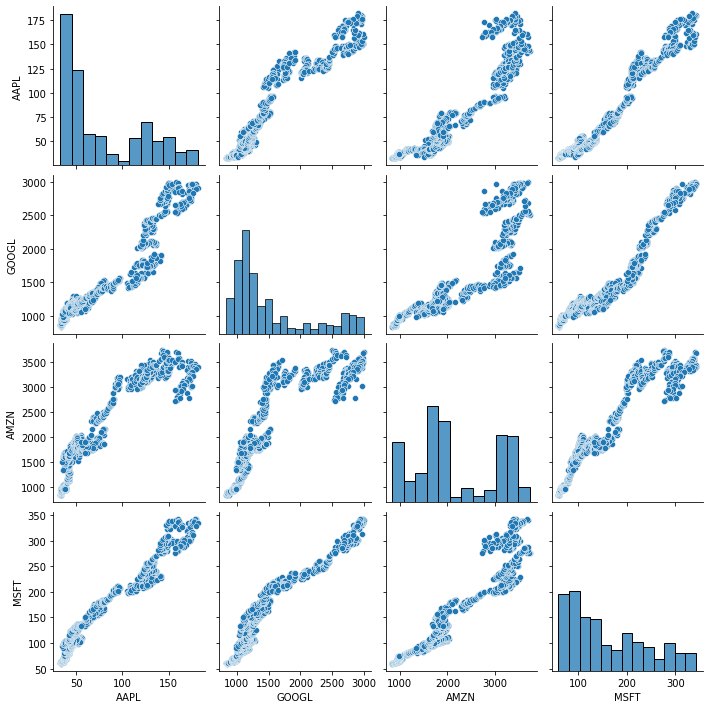

In [51]:
sns.pairplot(df)

Does this in fact mean what that we can predict prices of a stock based on their competition? The correlation does suggest so.

Let's try it!

First we'll try using a `LinearRegression` which simply said fits a line to be as close to all points as possible.

![linear regression wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/600px-Linear_regression.svg.png)
> Source: Wikipedia.org

First we import `LinearRegression` through `scikit-learn` and then we add `train_test_split` which allows us to split our data into a training and testing dataset.

Whenever you test your Machine Learning or Deep Learning Models you never want to test it on data that it has trained on, as you might've overfitted the data and have a really good result until you see new data points.

The end-goal of a model is to generalize a problem and find the local minima which optimizes the funtion for the data points. By only looking at the same data we can't be sure we generalized correctly.

And the code 👩‍💻

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

non_google_df = df.drop(columns="GOOGL")
X_train, X_valid, y_train, y_valid = train_test_split(non_google_df, df['GOOGL'], test_size=0.2)

clf = LinearRegression()

We got our data divided into `valid` and `train`, we got a regression model in our `clf`.

Let us predict the data and view our `r2_score` and `mean_absolute_error`.

> 💡  
> **r2_score:**  _(coefficient of determination) regression score function._  
> Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
>
> **mean_absolute_error:** _Mean absolute error regression loss._

In [53]:
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

r2_score(y_valid, preds), mean_absolute_error(y_valid, preds)

(0.9495278677136834, 120.88640110098741)

**$R^2 = 93 \%$** 🥳

That's actually not bad at all, the `mean_absolute_error` being 129.7 is not very telling. Either we have to view the data to understand the magnituide, or we can apply `MAPE` which is the _Mean Absolute Percentage Error_.  

Not sure if I'm lazy or simply want to show you the other function 🤔, but I'll use `MAPE`!

In [54]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_valid, preds)

0.07891126366405354

$< 9\%$  
Pretty acceptable considering we have not done anything except deliver data to one of the simplest models that exists!  

Let's show this visually!

In [55]:
import plotly.express as px

px.line(y=[y_valid, preds])

<details>
<summary>Show Plotly Chart (code cell only visible in active notebook)</summary>

<img src="simple-preds.png"/>
</details>

Looks pretty good, but it is very messy... Something is off right?

The index is not a `DateTimeIndex` anymore because we shuffled the data in `train_test_split` -- a big difference is thereby applied.

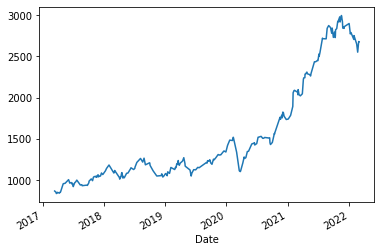

In [56]:
y_valid.plot()

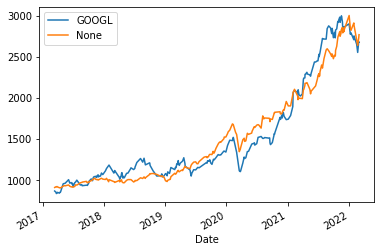

In [57]:
y_valid.plot(legend="Valid")
pd.Series(preds, index=y_valid.index).plot(legend="Pred")

Looks pretty fly, but can we take it further?  
...yes we can! 😎

I see a few options, the two first being:

1. Scaling the data as errors at the end are larger than in the beggining based on stocks rising.
2. `LinearRegression` is a very simple yet efficient model that we can try to replace.

Let's start with the second point, `scikit-learn` has a multitude of regression-models, one being `RandomForestRegressor` that's pretty strong.

In [58]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor()
clf.fit(X_train, y_train)

preds = clf.predict(X_valid)
r2_score(y_valid, preds), mean_absolute_percentage_error(y_valid, preds)

(0.9963567300739637, 0.016329169939121136)

😲$R^2 >99\%$

That's actually crazy. And `MAPE` is not even 2%.

Let's view it!

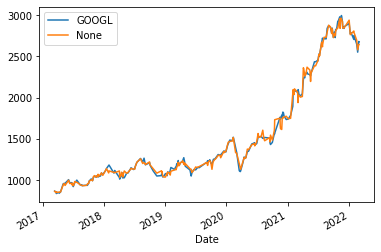

In [59]:
y_valid.plot(legend="Valid")
pd.Series(preds, index=y_valid.index).plot(legend="Pred")

That's an incredibly fitted curve.

**How is this possible?**  
1. We most likely overfit the data.  
2. We are looking at `AMZN`, `AAPL` and more data that is highly correlated during the **same** day as the one we wish to predict. 
  - In the end this is a **useless task**, if we know the prices of today we'd also know `GOOGL`'s prices!
3. We're using shuffled data, meaning that in a way we've seen the future and past values surrounding the predicted one. This is a regression problem and not really a forecasting problem, which is simpler than forecasting.

**Impressive nontheless**  
Even as I'm aware of all the drawbacks I'm thouroughly impresed by the results we're seeing.  

**Making it more interesting**  
We should make use of the previous days data to make sure we are not "cheating".

Let's get on it! 🎯

---

We'll be able to move, or _shift_, the data using ˋpd.DataFrame.shiftˋ which shifts the data either forwad ($+X$) or backwards ($-X$).

And while we're at it, let's group this up into a function.

> ℹ️  
> [`pd.DataFrame.shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html): _Shift index by desired number of periods with an optional time freq._  

In [60]:
def fit_validate_plot(X_train, X_valid, y_train, y_valid):
  clf = RandomForestRegressor()
  clf.fit(X_train, y_train)

  preds = clf.predict(X_valid)
  pd.DataFrame({'Valid': y_valid, 'Preds': preds}, index=y_valid.index).plot()
  
  print(f"""
  $R^2$: {r2_score(y_valid, preds)}
  MAPE: {mean_absolute_percentage_error(y_valid, preds)}
  MAE: {mean_absolute_error(y_valid, preds)}
  """)

And making use of it will now be easy! 😍  
_Refactoring_ and _abstractions_ are incredibly important.


  $R^2$: 0.993020486528333
  MAPE: 0.022105878493046974
  MAE: 32.473562898181726
  


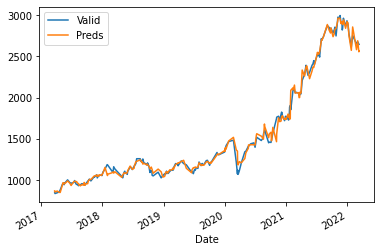

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns="GOOGL").shift(1).iloc[1:], df['GOOGL'].iloc[1:], test_size=0.2)

fit_validate_plot(X_train, X_valid, y_train, y_valid)

🤯 this is crazy impressive!

We made the task at hands legit by only using historical data of `GOOGL`'s competitors. The $R^2$  and `MAPE` is incredible.  

It'd be interesting to investigate how badly we overfit the data, but that's for another day.

And how about if we **don't** shuffle the data? E.g. we do an actual forecast and not regression!


  $R^2$: -7.266054917956771
  MAPE: 0.24703039286319634
  MAE: 675.8480126274956
  


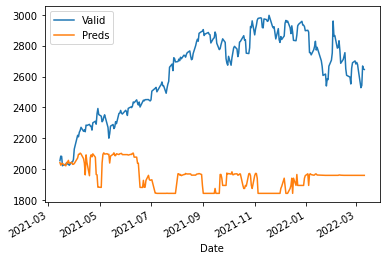

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns="GOOGL").shift(1).iloc[1:], df['GOOGL'].iloc[1:], test_size=0.2, shuffle=False)

fit_validate_plot(X_train, X_valid, y_train, y_valid)

🤯😭

What are we seeing and why?  
**Regression** algorithms/models try to fit a line to multiple points and it should be able to guess what point the data has depending on its features. In our case the regression algorithm has never seen data as high as above `y_train.max()`, which means it can't guess the data.

Don't trust me? Simply validate by looking at the chart 👆.

![](https://kagi.com/proxy/giphy.gif?c=tZl8lX5nYA-SXtLOSzNn-ptLUKm5FsSjvUOEfgN1REnlyKe27jFR0yp0jV69mnJIn7oABzGenQdoyNvQVaofhM7A_zXGa3_FEeM5n85RocE%3D)

What's one way to fix this? **Scaling**  
How will we try to achieve this practically? **LogReturn**

> 💡
> You can also take the %-difference, which according to Taylors Theorem will approximate the LogReturn.

In [64]:
def log_return(x: pd.DataFrame) -> pd.DataFrame:
  return x.apply(lambda x: np.log(x/x.shift(1))).dropna()

log_return(df).head()

Symbols,AAPL,GOOGL,AMZN,MSFT
Date,,,,
2017-03-14,-0.001510,0.001537,-0.002413,-0.004647
2017-03-15,0.010521,0.002860,0.000516,0.005265
2017-03-16,0.001636,0.001852,0.000527,-0.001700
2017-03-17,-0.004987,0.002720,-0.001301,0.003552
2017-03-20,0.010446,-0.005126,0.005453,0.000925



  $R^2$: -0.13772674709610588
  MAPE: 3.1419364874467086
  MAE: 0.01222694796828883
  


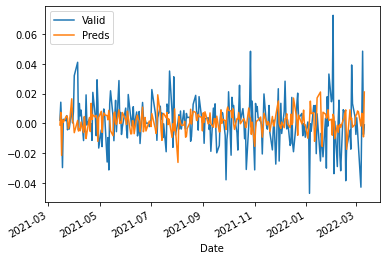

In [65]:
df_lr = log_return(df)
X_train, X_valid, y_train, y_valid = train_test_split(df_lr.drop(columns="GOOGL").shift(1).iloc[1:], df_lr['GOOGL'].iloc[1:], test_size=0.2, shuffle=False)

fit_validate_plot(X_train, X_valid, y_train, y_valid)

Most certainly **not** perfect... Forecasting seems harder than expected based on our initial results...  
And that's really because we weren't forecasting before, we were solving a _regression-problem_

Perhaps we need to use more data than simply the previous day?


### Predicting Based on historical performance
We might predict based on historical performance.

In [66]:
df.head()

Symbols,AAPL,GOOGL,AMZN,MSFT
Date,,,,
2017-03-13,32.856758,864.580017,854.590027,60.405796
2017-03-14,32.807198,865.909973,852.530029,60.125748
2017-03-15,33.154182,868.390015,852.969971,60.443142
2017-03-16,33.208458,870.000000,853.419983,60.340446
2017-03-17,33.043243,872.369995,852.309998,60.555161


In [67]:
df = df[['GOOGL']]
df.head()

Symbols,GOOGL
Date,
2017-03-13,864.580017
2017-03-14,865.909973
2017-03-15,868.390015
2017-03-16,870.000000
2017-03-17,872.369995


✅ Only Google Data  
❌ Historical Data

So what should we do? One way to solve this is to use `shift` multiple times.

In [68]:
def build_history(df: pd.DataFrame, num_back: int) -> pd.DataFrame:
  for i in range(num_back):
    df.loc[:, f"t_{i}"] = df['GOOGL'].shift(i + 1)
  
  return df

build_history(df, 3).head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Symbols,GOOGL,t_0,t_1,t_2
Date,,,,
2017-03-13,864.580017,NaN,NaN,NaN
2017-03-14,865.909973,864.580017,NaN,NaN
2017-03-15,868.390015,865.909973,864.580017,NaN
2017-03-16,870.000000,868.390015,865.909973,864.580017
2017-03-17,872.369995,870.000000,868.390015,865.909973


Notice how $t_0$ is the previous value, $t_1$ two steps back, and so on.  
This is actually _very_ memory intense as our data grows X times, one time per time step we build. In [part #3](INSERT) we'll go through how one can solve this issue.

No we need to drop all places where we don't have any history. That is easily achieved by dropping `NaN`.

> ℹ️  
> [`pd.DataFrame.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html): _Remove missing values._  
> `axis` attribute tells if you wish to drop rows or columns based on `NaN`, default is row.

In [69]:
df = build_history(df, 7)
df = df.dropna()
df.head()

Symbols,GOOGL,t_0,t_1,t_2,t_3,t_4,t_5,t_6
Date,,,,,,,,
2017-03-22,849.799988,850.140015,867.909973,872.369995,870.000000,868.390015,865.909973,864.580017
2017-03-23,839.650024,849.799988,850.140015,867.909973,872.369995,870.000000,868.390015,865.909973
2017-03-24,835.140015,839.650024,849.799988,850.140015,867.909973,872.369995,870.000000,868.390015
2017-03-27,838.510010,835.140015,839.650024,849.799988,850.140015,867.909973,872.369995,870.000000
2017-03-28,840.630005,838.510010,835.140015,839.650024,849.799988,850.140015,867.909973,872.369995


LGTM ✅

---

Let's scale our data and then make predictions.  
As previously,

1. Scale data
2. Split data
3. Fit data
4. Predict data
5. Validate


  $R^2$: -0.12436497765470134
  MAPE: 2.020486730297106
  MAE: 0.011961155812517109
  


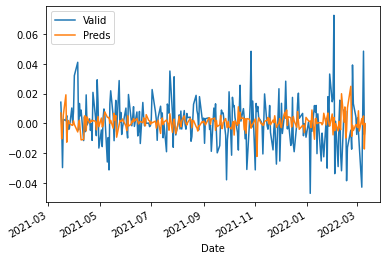

In [70]:
df_lr = log_return(df)
X_train, X_valid, y_train, y_valid = train_test_split(df_lr.iloc[:, 1:], df_lr['GOOGL'], test_size=0.2, shuffle=False)

fit_validate_plot(X_train, X_valid, y_train, y_valid)

Not great, not awful. Some self-exercises:

1. How would we do without scaling?
2. How would we do without shuffling?
3. Any other ideas? Try 'em out!

In [71]:
# Test your own ideas

If you didn't try previously, try appling a rolling mean and rerun  `fit_validate_plot` as this should reduce the "swings" and thereby be a little bit more predictable.

> 💡
> [`pd.DataFrame.Rolling`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html): _Provide rolling window calculations._  
> In other words: We slide a window on our data and do calculations, in our case `mean`. This window includes `window`, `min_periods`, `center` & more attributes which impacts size of window, how large minimal window can be, and more.

Validating what `rolling.mean()` does to our data:

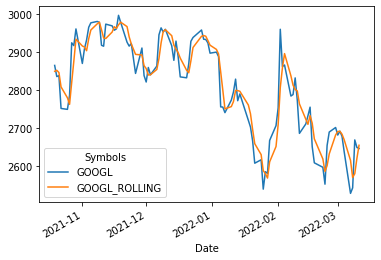

In [79]:
df['GOOGL_ROLLING'] = df['GOOGL'].rolling(3).mean()  # Rolling over 3 days mean
df[-100:].plot(y=['GOOGL', 'GOOGL_ROLLING'])

Zooming 🔍

In [73]:
df_last_months = df[df.index > datetime(2021, 6, 6)]

df_last_months.plot(y=['GOOGL', 'GOOGL_ROLLING'], backend='plotly')

<details>
<summary>Show Plotly Chart (code cell only visible in active notebook)</summary>

<img src="zoom-preds.png"/>
</details>

The curve is _very_ similar, but different.  

> **Self-exercise**: Test applying different functions like `min`, `max` and expanding window size into more days.

And validating what this does to our prediction.


  $R^2$: 0.8925898146393952
  MAPE: 0.7957020086330117
  MAE: 0.0020138783337579776
  


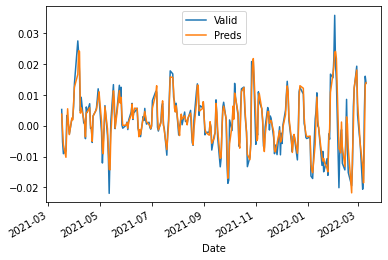

In [74]:
df_lr = df.pct_change().dropna().rolling(3).mean().dropna()
X_train, X_valid, y_train, y_valid = train_test_split(df_lr.iloc[:, 1:], df_lr['GOOGL'], test_size=0.2, shuffle=False)

fit_validate_plot(X_train, X_valid, y_train, y_valid)

We're back! 🥳

It's not perfect, but we got something. And we can work with something. We can work with something... :)

> **Self-exercise**: Validat how `rolling` would affect our non-history-based forecasting

Let's reverse our transformation to see what we'd actually predict in the end.

In [75]:
y_rolling = df['GOOGL'].rolling(3).mean().dropna()
y_train_non_scaled, y_valid_non_scaled = train_test_split(y_rolling, test_size=0.2, shuffle=False)

In [80]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)

preds = (preds + 1).cumprod() # Cummulative multiplication, first day + 1%, but then we got -1%, that's 1.01 * 0.99
preds = preds * y_train_non_scaled.iloc[-1] # Scaling it up based on the last training value

pd.DataFrame({'Preds': preds, 'Valid Rolling': y_valid_non_scaled[1:], 'Valid': df['GOOGL'].iloc[-len(preds):]}).plot(backend='plotly')

<details>
<summary>Show Plotly Chart (code cell only visible in active notebook)</summary>

<img src="final-preds.png"/>
</details>

Seems as we're a little low in our predictions, but the curve is followed after all.

**What issues are left?**

1. We are not using an `AutoRegressive` model which might be interesting.
  - More about this in the next session
2. We are not using the "better" models, e.g. Neural Networks or statistic-model for Time Series like `ARIMA`.

Personally I'm very pleased with the results and can't wait to get started on **part #3**!

---

To learn more about Time Series and how one can analyze them please view the other parts,

1. [Part One - Decomposing & Working with Time Series (theoretical)](https://blog.londogard/timeseries-pt-1)
2. [Part Two - Predicting Stock Prices (Time Series) using classical Machine Learning](https://blog.londogard/timeseries-pt-2)
3. [Part Three -Forecasting Cryptocurrency Prices (Time Series) using Deep Learning (PyTorch, Tensorflow/Keras & darts)](https://blog.londogard/timeseries-pt-3)


---


#### Extra Self Exercises

1. Try different window-sizes with `rolling`
1. Try different length of history to predict new result on
1. Test new architectures
1. Find your own way to improve the results